# 2. Facial Embeddings

Nowadays, to create a facial recognition model, we don't need to train our own model. Experts has helped us to pre-train a model, we just need to learn how to use it. This notebook will teach you how to use their deep learning models on your own dataset, try out multiple cutting-edge models, and compare their performances.

In [1]:
import cv2
import matplotlib.pyplot as plt
import keras_vggface as kv
import modules.utils as utils
from tensorflow.keras.models import save_model
import tensorflow as tf
from tensorflow.python.keras.engine import training
from tensorflow import keras
import os
from statistics import mean
import pandas as pd

## Face Preprocess

Here we will use the `FacePreprocess` module to clean and normalize the input image before input to the deep learning model.

In [2]:
from modules.FacePreprocess import FacePreprocess
ssd_model = r'./models/ssd/deploy.prototxt.txt'
ssd_weights = r'./models/ssd/res10_300x300_ssd_iter_140000.caffemodel'
processor = FacePreprocess(ssd_model, ssd_weights)

Text(0.5, 1.0, 'Preprocessed')

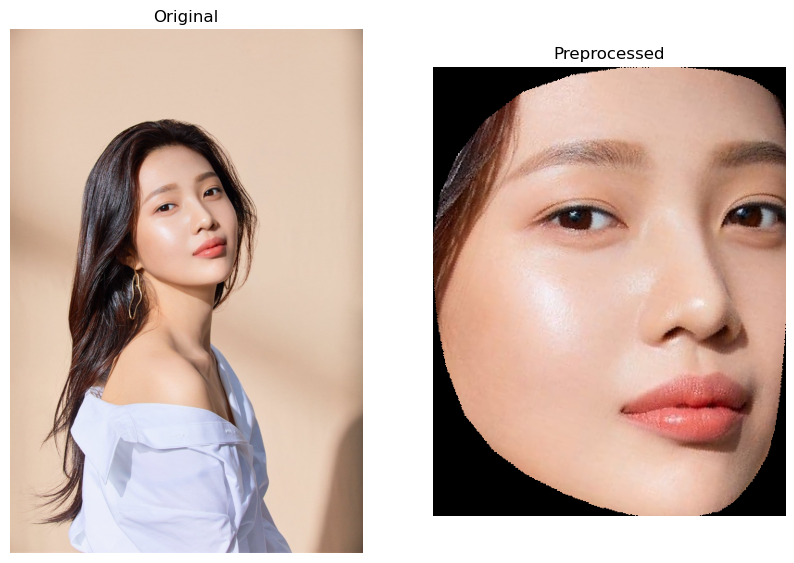

In [3]:
img_path = './dataset/train/joy/img_1.jpg'
img = cv2.imread(img_path)
processed_img = processor.preproc(img)[0][0]

fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 2, 1)  
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Original")
fig.add_subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Preprocessed")

## Compute Facial Embeddings

In this step, we will take our input image and insert them into the deep learning models. These models will compute embeddings of our input image, which we will use to compare with the embeddings of other images.

In [4]:
# stores list of models
models = {}

#### ⭐ keras-vggface (kv)
source: https://github.com/rcmalli/keras-vggface

\>\> resnet50

In [5]:
model = kv.VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
models['kv-resnet50'] = [model, (224,224)]
img_representation = model.predict(utils.resize(processed_img, (224, 224)))[0,:]

1/1 [==============================] - 1s 761ms/step


\>\> senet50

In [6]:
model = kv.VGGFace(model='senet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
models['kv-senet50'] = [model, (224,224)]
img_representation = model.predict(utils.resize(processed_img, (224, 224)))[0,:]

1/1 [==============================] - 1s 1s/step


\>\> vgg16

In [7]:
model = kv.VGGFace(model='vgg16', include_top=False, input_shape=(224, 224, 3), pooling='avg')
models['kv-vgg16'] = [model, (224,224)]
img_representation = model.predict(utils.resize(processed_img, (224, 224)))[0,:]

1/1 [==============================] - 0s 239ms/step


#### ⭐ ArcFace
source: https://sefiks.com/2020/12/14/deep-face-recognition-with-arcface-in-keras-and-python/

In [8]:
model = keras.models.load_model('./models/arcface/model.keras', compile=False)
models['arcface'] = [model, (112,112)]
img_representation = model.predict(utils.resize(processed_img, (112, 112)))[0,:]

1/1 [==============================] - 1s 843ms/step


#### ⭐ Facebook DeepFace
source: https://sefiks.com/2020/02/17/face-recognition-with-facebook-deepface-in-keras/

In [16]:
model = keras.models.load_model('./models/deepface/model.keras', compile=False)
models['deepface'] = [model, (152,152)]
img_representation = model.predict(utils.resize(processed_img, (152, 152)))[0,:]

1/1 [==============================] - 43s 43s/step


#### ⭐ Google Facenet
source: https://sefiks.com/2018/09/03/face-recognition-with-facenet-in-keras/

In [17]:
model = keras.models.load_model('./models/facenet/model.keras', compile=False)
models['facenet'] = [model, (160,160)]
img_representation = model.predict(utils.resize(processed_img, (160, 160)))[0,:]

1/1 [==============================] - 2s 2s/step


## Compare Embeddings of the Images

The general idea is to compare the vector distance of the images, using the embeddings from the models. In theory, two images of the same person should have a closer distance than two images of different people. Here I use cosine distance and euclidean distance to compare, but other vector distance calculation methods can be used too.


\>\> `./dataset/train/joy/img_1` vs `./dataset/train/joy/img_2`

In [11]:
img2_path = './dataset/train/joy/img_2.jpg'
processed_img2 = processor.preproc(cv2.imread(img2_path))[0][0]

table = []
for key, value in models.items():
    img1_r = value[0].predict(utils.resize(processed_img, value[1]), verbose=False)[0,:]
    img2_r = value[0].predict(utils.resize(processed_img2, value[1]), verbose=False)[0,:]

    table.append([key, utils.findCosineSimil(img1_r, img2_r), utils.findEuclideanDistance(utils.L2_normalize(img1_r), utils.L2_normalize(img2_r))])
pd.DataFrame(table, columns=['model name', 'cosine similarity', 'euclidean distance'])

,model name,cosine similarity,euclidean distance
0,kv-resnet50,0.150052,0.547818
1,kv-senet50,0.199563,0.631764
2,kv-vgg16,0.082530,0.406275
3,arcface,0.029055,0.241062
4,deepface,0.123780,0.497554
5,facenet,0.017836,0.188873


\>\> `./dataset/train/joy/img_1` vs `./dataset/train/irene/img_2`

In [12]:
img2_path = './dataset/train/irene/img_2.jpg'
processed_img2 = processor.preproc(cv2.imread(img2_path))[0][0]

table = []
for key, value in models.items():
    img1_r = value[0].predict(utils.resize(processed_img, value[1]), verbose=False)[0,:]
    img2_r = value[0].predict(utils.resize(processed_img2, value[1]), verbose=False)[0,:]

    table.append([key, utils.findCosineSimil(img1_r, img2_r), utils.findEuclideanDistance(utils.L2_normalize(img1_r), utils.L2_normalize(img2_r))])
pd.DataFrame(table, columns=['model name', 'cosine similarity', 'euclidean distance'])

,model name,cosine similarity,euclidean distance
0,kv-resnet50,0.507460,1.007432
1,kv-senet50,0.431853,0.929358
2,kv-vgg16,0.159190,0.564252
3,arcface,0.069125,0.371819
4,deepface,0.542874,1.041992
5,facenet,0.038586,0.277800


We can see that the distances for `joy/img_1 vs joy/img_2` is closer than `joy/img_1 vs irene/img_2`. The closer the distance, the more similar the person in both pictures are. For the models which predicted wrongly, it doesn't mean that the model is bad, it simply means that the model doesn't suit our dataset. Not one model is better than the other, some models just suit our dataset better than others. A lot of trial and error is needed to find the most suitable one for your dataset!

## Compare Models

In this part, we want to compare the performance of our models, by computing the distance between `./dataset/train/joy/img_1` and every other image in the dataset. The printed outputs are the average distance between `./dataset/train/joy/img_1` and the images in each folder.

#### ⭐ cosine similarity

&ensp;&ensp;&ensp; $\ d(\mathbf{p}, \mathbf{q}) = 1 - \frac{p^\top q}{\sqrt{p^\top p} \sqrt{q^\top q}} $

In [13]:
table = []
for key, value in models.items():
    img1_r = value[0].predict(utils.resize(processed_img, value[1]), verbose=False)[0,:]

    header = ['model name']
    avg = [key]
    for id in os.listdir('./dataset/train'):
        dist = []
        header.append(id)
        for i in range(1,6):
            if id == 'joy' and i == 1: # skip because distance of the same image will be 0
                continue

            processed_img2 = processor.preproc(cv2.imread('./dataset/train/{}/img_{}.jpg'.format(id, str(i))))[0][0]
            img2_r = value[0].predict(utils.resize(processed_img2, value[1]), verbose=False)[0,:]
            dist.append(utils.findCosineSimil(img1_r, img2_r))
        avg.append(mean(dist))
    table.append(avg)

cos_table = pd.DataFrame(table, columns=header)
cos_table

,model name,irene,joy,seulgi,wendy,yeri
0,kv-resnet50,0.475705,0.190270,0.523825,0.503674,0.369606
1,kv-senet50,0.400462,0.184694,0.507883,0.449515,0.276956
2,kv-vgg16,0.157516,0.101388,0.159757,0.210740,0.135713
3,arcface,0.075666,0.051817,0.082273,0.089988,0.082636
4,deepface,0.575728,0.391662,0.534413,0.587885,0.383533
5,facenet,0.041348,0.028939,0.034994,0.081142,0.055212


The distance for `joy` should be lower than the distance in the other columns. All the models (except for `deepface`) performs as expected.

#### ⭐ euclidean distance

&ensp;&ensp;&ensp; L<sup>2</sup> norm &rarr; $\ ||x||_2 = \sqrt{\sum_{i=1}^{n} x_i} $

&ensp;&ensp;&ensp; Euclidean dist. &rarr; $\ d(\mathbf{p}, \mathbf{q}) = \sqrt{\sum_{i=1}^{n} (||q_i||_2 - ||p_i||_2)^2} $

In [14]:
table = []
for key, value in models.items():
    img1_r = value[0].predict(utils.resize(processed_img, value[1]), verbose=False)[0,:]

    header = ['model name']
    avg = [key]
    for id in os.listdir('./dataset/train'):
        dist = []
        header.append(id)
        for i in range(1,6):
            if id == 'joy' and i == 1: # skip because distance of the same image will be 0
                continue

            processed_img2 = processor.preproc(cv2.imread('./dataset/train/{}/img_{}.jpg'.format(id, str(i))))[0][0]
            img2_r = value[0].predict(utils.resize(processed_img2, value[1]), verbose=False)[0,:]
            dist.append(utils.findEuclideanDistance(utils.L2_normalize(img1_r), utils.L2_normalize(img2_r)))
        avg.append(mean(dist))
    table.append(avg)

eucl_table = pd.DataFrame(table, columns=header)
eucl_table

,model name,irene,joy,seulgi,wendy,yeri
0,kv-resnet50,0.974617,0.615195,1.023291,1.002925,0.859714
1,kv-senet50,0.894149,0.606855,1.006750,0.947568,0.743871
2,kv-vgg16,0.561125,0.449441,0.564996,0.647935,0.520479
3,arcface,0.388137,0.307850,0.397657,0.414719,0.389383
4,deepface,1.072496,0.855353,1.030867,1.083326,0.850898
5,facenet,0.277408,0.237135,0.258184,0.370390,0.316507


The distance for `joy` should be lower than the distance in the other columns. All the models (except for `deepface`) performs as expected.

Between all these models, how to pick the most suitable model? We want to pick the model in which the _'wrong class'_ has the furthest distance from the _'correct class'_. Below is a simple code to check (there are better ways to write the code but since our dataset is small this will do)

In [18]:
table = []
for i, row in cos_table.iterrows():
    tmp = [row['model name']]

    # cosine
    tmp.append(mean([row['irene'], row['seulgi'], row['wendy'], row['yeri']]))
    # euclid
    tmp.append(mean([eucl_table['irene'][i], eucl_table['seulgi'][i], eucl_table['wendy'][i], eucl_table['yeri'][i]]))
    
    table.append(tmp)

df = pd.DataFrame(table, columns=['model name', 'cosine', 'euclidean'])
df.sort_values(['cosine', 'euclidean'], ascending=False)

,model name,cosine,euclidean
4,deepface,0.520390,1.009397
0,kv-resnet50,0.468202,0.965137
1,kv-senet50,0.408704,0.898085
2,kv-vgg16,0.165932,0.573634
3,arcface,0.082641,0.397474
5,facenet,0.053174,0.305622


The table above shows the average distance of the _'wrong class'_. As we can see, the top model for our dataset are kv-resnet50 (`deepface` predicted wrongly, so we'll ignore that) Keep in mind that these numbers are specific to this dataset only. Your dataset might have different results.

## Conclusion

This notebook's purpose is to try out different cutting-edge machine learning models, and it works well with small datasets. However, with larger datasets, we need a better method to compare distances. Check out the next notebook!